In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Fri Jan 12 00:12:14 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    13W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-3/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 345228
-rw-rw-r-- 1 scpark scpark  1140164  1월 12 00:12 events.out.tfevents.1704985359.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37979741  1월 12 00:10 save_10000
-rw-rw-r-- 1 scpark scpark 37973949  1월 12 00:02 save_0
-rw-rw-r-- 1 scpark scpark   848900  1월 12 00:02 events.out.tfevents.1704984915.GPUSVR01
-rw-rw-r-- 1 scpark scpark   364100  1월 11 23:55 events.out.tfevents.1704984721.GPUSVR01
-rw-rw-r-- 1 scpark scpark  1131332  1월 11 22:02 events.out.tfevents.1704977572.GPUSVR01
-rw-rw-r-- 1 scpark scpark   959684  1월 11 21:52 events.out.tfevents.1704977079.GPUSVR01
-rw-rw-r-- 1 scpark scpark  5455110  1월 11 21:44 events.out.tfevents.1704974489.GPUSVR01
-rw-rw-r-- 1 scpark scpark 66192541  1월 11 21:39 save_50000
-rw-rw-r-- 1 scpark scpark 66192541  1월 11 21:31 save_40000
-rw-rw-r-- 1 scpark scpark 66192541  1월 11 21:23 save_30000
-rw-rw-r-- 1 scpark scpark 66192541  1월 11 21:16 save_20000
-rw-rw-r-- 1 scpark scpark   468932  1월 11 21:01 events.out.tfevents.1704974255.GPUSVR01
-rw-rw-r

### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


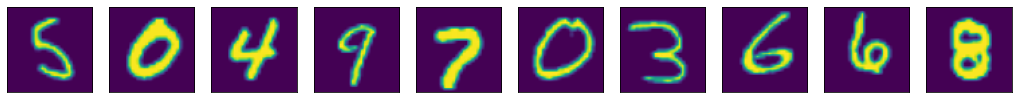

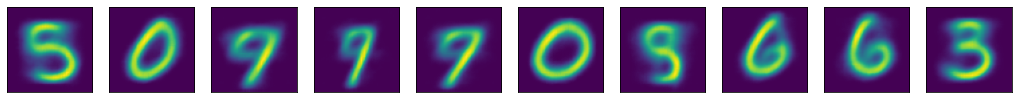

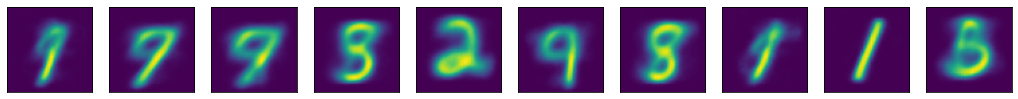

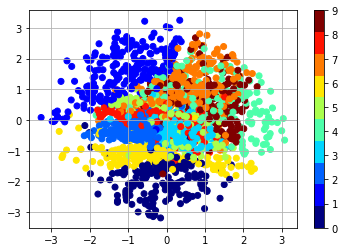

50001
lse_loss -0.34652671217918396
recon_loss 0.1340210735797882
50002
lse_loss -0.3622051179409027
recon_loss 0.1363275945186615
50003
lse_loss -0.4325585961341858
recon_loss 0.1379062682390213
50004
lse_loss -0.3307860195636749
recon_loss 0.1425277292728424
50005
lse_loss -0.342620849609375
recon_loss 0.14821162819862366
50006
lse_loss -0.3677643835544586
recon_loss 0.14990872144699097
50007
lse_loss -0.22613851726055145
recon_loss 0.15936648845672607
50008
lse_loss -0.3318863809108734
recon_loss 0.14623811841011047
50009
lse_loss -0.3504060208797455
recon_loss 0.13642846047878265
50010
lse_loss -0.3019675612449646
recon_loss 0.14353881776332855
50011
lse_loss -0.2759895324707031
recon_loss 0.15655633807182312
50012
lse_loss -0.2982986867427826
recon_loss 0.1514185070991516
50013
lse_loss -0.3437961935997009
recon_loss 0.16965703666210175
50014
lse_loss -0.3468134105205536
recon_loss 0.14704665541648865
50015
lse_loss -0.3062360882759094
recon_loss 0.14610376954078674
50016
lse_loss

lse_loss -0.3547587990760803
recon_loss 0.1353672742843628
50129
lse_loss -0.3671039938926697
recon_loss 0.14278855919837952
50130
lse_loss -0.31552183628082275
recon_loss 0.13779447972774506
50131
lse_loss -0.3608425259590149
recon_loss 0.139516681432724
50132
lse_loss -0.35283368825912476
recon_loss 0.15484970808029175
50133
lse_loss -0.3489210307598114
recon_loss 0.1437879204750061
50134
lse_loss -0.30774399638175964
recon_loss 0.14456024765968323
50135
lse_loss -0.3076516091823578
recon_loss 0.145076185464859
50136
lse_loss -0.33481019735336304
recon_loss 0.13218486309051514
50137
lse_loss -0.36699774861335754
recon_loss 0.1358131766319275
50138
lse_loss -0.2599988281726837
recon_loss 0.150222048163414
50139
lse_loss -0.3344298303127289
recon_loss 0.15020519495010376
50140
lse_loss -0.349241703748703
recon_loss 0.14186562597751617
50141
lse_loss -0.37252792716026306
recon_loss 0.14048747718334198
50142
lse_loss -0.3790719509124756
recon_loss 0.1362571120262146
50143
lse_loss -0.276

50256
lse_loss -0.3551194667816162
recon_loss 0.13749544322490692
50257
lse_loss -0.364698588848114
recon_loss 0.146033376455307
50258
lse_loss -0.3375749886035919
recon_loss 0.14950454235076904
50259
lse_loss -0.35953015089035034
recon_loss 0.1426701545715332
50260
lse_loss -0.38292041420936584
recon_loss 0.14485211670398712
50261
lse_loss -0.35005640983581543
recon_loss 0.14618055522441864
50262
lse_loss -0.34356099367141724
recon_loss 0.14351719617843628
50263
lse_loss -0.34616389870643616
recon_loss 0.14821386337280273
50264
lse_loss -0.3123117983341217
recon_loss 0.13630399107933044
50265
lse_loss -0.3720436990261078
recon_loss 0.1360265016555786
50266
lse_loss -0.2993493676185608
recon_loss 0.12632595002651215
50267
lse_loss -0.4050620198249817
recon_loss 0.1497775912284851
50268
lse_loss -0.34762221574783325
recon_loss 0.14439383149147034
50269
lse_loss -0.247416153550148
recon_loss 0.14340442419052124
50270
lse_loss -0.3129107356071472
recon_loss 0.14268678426742554
50271
lse_l

50382
lse_loss -0.3842969238758087
recon_loss 0.14524701237678528
50383
lse_loss -0.39858242869377136
recon_loss 0.13632842898368835
50384
lse_loss -0.3151088356971741
recon_loss 0.14365582168102264
50385
lse_loss -0.3781125247478485
recon_loss 0.14444439113140106
50386
lse_loss -0.3814656436443329
recon_loss 0.1371731013059616
50387
lse_loss -0.23049794137477875
recon_loss 0.14236187934875488
50388
lse_loss -0.3523083031177521
recon_loss 0.1354459524154663
50389
lse_loss -0.35738009214401245
recon_loss 0.1335059106349945
50390
lse_loss -0.3876250386238098
recon_loss 0.13719849288463593
50391
lse_loss -0.3323175311088562
recon_loss 0.14843998849391937
50392
lse_loss -0.36326491832733154
recon_loss 0.12796513736248016
50393
lse_loss -0.3751700818538666
recon_loss 0.14612993597984314
50394
lse_loss -0.3310973346233368
recon_loss 0.1376551389694214
50395
lse_loss -0.33220580220222473
recon_loss 0.13408267498016357
50396
lse_loss -0.36557459831237793
recon_loss 0.13706272840499878
50397
ls

50507
lse_loss -0.3607717752456665
recon_loss 0.13963527977466583
50508
lse_loss -0.33026400208473206
recon_loss 0.14636874198913574
50509
lse_loss -0.3387207090854645
recon_loss 0.13864998519420624
50510
lse_loss -0.37051689624786377
recon_loss 0.1439359188079834


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=10000, sigma=2e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-2)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        